In [52]:
import os
import sys
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
from talib import RSI
from multiprocessing import Pool, cpu_count
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
import warnings
from time import time, sleep

warnings.filterwarnings('ignore')

# To display multiple outputs from the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('max_colwidth', 400)
pd.set_option('display.expand_frame_repr', True)


%matplotlib inline
!python -V

Python 3.8.10


### Q1: Backtest a strategy using three moving averages on any indices such as Nifty50, SPY, HSI and so on. ###
1. Compute three moving averages of 20, 40, and 80.
2. Go long when the price crosses above all three moving averages.
3. Exit the long position when the price crosses below any of the three moving averages.
4. Go short when the price crosses below all three moving averages.
5. Exit the short position when the price crosses above any of the three moving averages.
6. Optional: Optimise all three moving averages

In [53]:
asset= "SPY"
start_date = datetime(2010, 1, 2)
end_date = datetime(2022, 6, 30)
def download_data(ticker, start = start_date, end = end_date):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified. If dates are not specified
    they default from 2015 up until now. Then, It prints different metrics
    """
    data = yf.download(ticker, start, end)
    #signals:
    print(data.tail())
    print(data.shape)
    print(data.isna().sum())
    print(f"shape with NaN values: {data.shape}")
    data.dropna(inplace=True)
    print(f"shape after deleting NaN values: {data.shape}")

    return data

In [54]:
raw_data = download_data(asset, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-23  376.640015  378.829987  372.890015  378.059998  378.059998   
2022-06-24  381.399994  390.089996  381.369995  390.079987  390.079987   
2022-06-27  391.049988  391.359985  387.440002  388.589996  388.589996   
2022-06-28  390.230011  393.160004  380.529999  380.649994  380.649994   
2022-06-29  381.230011  382.269989  378.420013  380.339996  380.339996   

              Volume  
Date                  
2022-06-23  79292100  
2022-06-24  98050300  
2022-06-27  66009600  
2022-06-28  86548900  
2022-06-29  65676000  
(3144, 6)
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
shape with NaN values: (3144, 6)
shape after deleting NaN values: (3144, 6)


In [180]:
class Triple_SMA_Strategy():
    def __init__(self, df, lookback_list, multiparallelism = False):
        self.data = df.copy()
        self.lookback = lookback_list
        self.mp = multiparallelism
        self.sma_high = 'sma' + str(self.lookback[0])
        self.sma_medium = 'sma' + str(self.lookback[1])
        self.sma_low = 'sma' + str(self.lookback[2])
        self.compute_indicators()
        self.signals()
        self.positions()
        
    
    def compute_indicators(self):
        """
        The function creates additional columns to an OHLC pandas DataFrame
        required to backtest the "Triple SMA" trading strategy and then display them
        """
        
        self.data["Adj Close prev_day"] = self.data["Adj Close"].shift(1)

        for period in self.lookback:
            self.data["sma" + str(period)] = self.data['Adj Close'].rolling(window=period, center=False).mean()
            self.data["sma" + str(period) + '_prev_day'] = self.data["sma" + str(period)].shift(1)
          

        # indicator to be considered for entering long positions
        self.data["sma_max"] = self.data[[self.sma_high, self.sma_medium, self.sma_low]].max(axis=1)
        self.data["sma_max_prev_day"] = self.data[[self.sma_high + '_prev_day', self.sma_medium + '_prev_day', self.sma_low + '_prev_day']].max(axis=1)
        
        # indicator to be considered for entering short positions
        self.data["sma_min"] = self.data[[self.sma_high, self.sma_medium, self.sma_low]].min(axis=1)
        self.data["sma_min_prev_day"] = self.data[[self.sma_high + '_prev_day', self.sma_medium + '_prev_day', self.sma_low + '_prev_day']].min(axis=1)
        
        #print(f"shape before deleting NaN values: {self.data.shape}")
        self.data.dropna(inplace=True)
        #print(f"shape after deleting NaN values: {self.data.shape}")
        #self.data[['Adj Close', self.sma_high, self.sma_medium, self.sma_low]].plot(grid=True, linewidth=2, figsize=(15, 8));
        #print(self.data.iloc[80:90])

        
    
    def signals(self):
        """
        The function computes the signal with the following rules:
        1) Go long when the price crosses above all three moving averages one minute before market closes
        2) Exit the long position when the price crosses below any of the three moving averages one minute before market closes
        3) Go short when the price crosses below all three moving averages one minute before market closes
        4) Exit the short position when the price crosses above any of the three moving averages one minute before market closes
        
        NOTE: We enter the position one minute before market closes. This implies that we are making an approximation that the "Adj Close"
        is almost the same as the Price one minute earlier. this is dome to avoid lookahead bias.
        Another option could be to enter the position at the start of the next day trading session
        """
        
        #signals:
        # we need three symbols to represent the states:
        #  1 for long position
        # -1 for short positions
        #  0 for idle positions
        
        self.data["signal"] = -1.1 # default signal
        
        # long position enter signal
        self.data['signal'] = np.where((self.data['Adj Close'] > self.data['sma_max']) 
                        & (self.data['Adj Close prev_day'] < self.data['sma_max_prev_day']), 1, -1.1)
        # long position exit signal
        self.data['signal'] = np.where( (self.data['Adj Close prev_day'] > self.data['sma_max_prev_day'])
                        & (self.data['Adj Close'] < self.data['sma_max']) & (self.data['Adj Close'] > self.data['sma_min']), 0, self.data['signal'])
        
        # short position enter signalfrom dataframe
        self.data['signal'] = np.where((self.data['Adj Close'] < self.data['sma_min']) 
                        & (self.data['Adj Close prev_day'] > self.data['sma_min_prev_day']), -1, self.data['signal'])
        
        # short position exit signal
        self.data['signal'] = np.where((self.data['Adj Close prev_day'] < self.data['sma_min_prev_day']) 
                        & (self.data['Adj Close'] > self.data['sma_min']) & (self.data['Adj Close'] < self.data['sma_max']), 0, self.data['signal'])
        
        if not self.mp:
            print(self.data['signal'].value_counts())
            #print(self.data.loc["2021-10-01":"2021-11-30"])
    
    def positions(self):
        '''
        The function computes the positions
        '''
        self.data['position'] = self.data['signal'].replace(to_replace=-1.1, method='ffill')
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones of Buy&Hold Strategy 
        and the Triple SMA Strategy
        '''
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        self.data['triple_sma_strategy'] = self.data['buy_and_hold'] * self.data['position'].shift(1)
        
        if not self.mp:
            print("\n", "-" * 60)
            print(f"fast SMA: {self.lookback[0]}, medium SMA: {self.lookback[1]}, slow SMA: {self.lookback[2]}")
            print(f"Buy & Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Triple SMA Strategy returns (simple): {((1 + self.data['triple_sma_strategy']).cumprod()[-1] -1) * 100:.2f}%")
            
        else:
            sma_high_lookback= self.lookback[0]
            sma_medium_lookback= self.lookback[1]
            sma_low_lookback= self.lookback[2]
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['triple_sma_strategy']).cumprod()[-1] -1) * 100
            #print(sma_high_lookback, sma_medium_lookback, sma_low_lookback)
            #print(buy_and_hold_return, strategy_return)
            return (sma_high_lookback, sma_medium_lookback, sma_low_lookback, buy_and_hold_return, strategy_return)
        
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of Buy&Hold Strategy 
        and the Triple SMA Strategy using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["Adj Close", "sma_max", "sma_min", 'position']].plot(figsize=(20, 12), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['triple_sma_strategy'] = 1 + self.data['triple_sma_strategy']
        self.data[['buy_and_hold','triple_sma_strategy']].cumprod().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & Hold' vs 'triple SMA Strategy' cumulative returns")
        plt.show()
        
        # General analytics
        pf.create_full_tear_sheet(self.data["triple_sma_strategy"] -1, benchmark_rets=None)
    
    def optimize_strategy(self, raw_data):
        '''
        The function uses multiprocessing (this is a CPU-bound job) to optimize in parallel different combinations of lookbacks
        for the Triple SMA strategy.
        '''
        
        # grid-search with brute force using multi-processing
        sma_high_range =   [20, 40]
        sma_medium_range = [40, 100]
        sma_low_range =    [100, 300]
        step_size = 5
        
        sma_high= list(np.arange(sma_high_range[0], sma_high_range[1], step_size))
        sma_medium = list(np.arange(sma_medium_range[0], sma_medium_range[1], step_size))
        sma_low = list(np.arange(sma_low_range[0], sma_low_range[1], step_size))
        list_of_lookbacks = list(product(*[sma_high, sma_medium, sma_low])) 
            
        prepared_list = []
        for i in range(len(list_of_lookbacks)):
            #prepared_list.append((raw_data, [list_of_lookbacks[i][0], list_of_lookbacks[i][1], list_of_lookbacks[i][2]],  True))
            prepared_list.append((raw_data, *[list_of_lookbacks[i]],  True))
            #print([list_of_lookbacks[i][0], list_of_lookbacks[i][1], list_of_lookbacks[i][2]])
        
        start_time = time()
        # I've got 16 CPU on my PC
        print(f"num of cpus being used: {max(1, cpu_count() - 1)}")
        with Pool(processes = max(1, cpu_count() - 1)) as mp_pool:
            results = mp_pool.starmap(Triple_SMA_Strategy, prepared_list)
        
        #print(results)
        fast_sma = []
        medium_sma = []
        slow_sma = []
        buy_and_hod_returns = []
        strategy_returns = []
        
        for res in results:
            v = res.returns()
            fast_sma.append(v[0]), medium_sma.append(v[1]), slow_sma.append(v[2])
            buy_and_hod_returns.append(v[3]), strategy_returns.append(v[4])
            
        # Convert into a DataFrame
        df_results = pd.DataFrame({'fast_sma':fast_sma, 'medium_sma': medium_sma, 'slow_sma': slow_sma, \
                                   'strategy_returns': strategy_returns})
        print(df_results.head(10).sort_values(by= 'strategy_returns', ascending=False))
        print(df_results.describe())
        
        print(f"\nEverything took {(time() -  start_time):.2f} sec. to complete")
        
        # plotting a 4D dimensional graph using a sampled dateset
        df_sampled = df_results.sample(frac=0.1)
        # 3D view of the dataframe
        fig = plt.figure(figsize=(20, 12))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('slow_sma')
        ax.set_ylabel('medium_sma')
        ax.set_zlabel('fast_sma')
        ax.set_xlim3d(100, 300)
        ax.set_ylim3d(40, 100)
        ax.set_zlim3d(20, 40)
        #surf=ax.plot_trisurf(df_results['fast_sma'], df_results['slow_sma'], df_results['strategy_returns'], cmap=plt.cm.viridis, linewidth=0.2)
        #fig.colorbar( surf, shrink=0.5, aspect=5)
        #img = ax.scatter(df_sampled["slow_sma"], df_sampled["medium_sma"], df_sampled["fast_sma"], c=df_sampled["strategy_returns"], cmap=plt.hot())
        img = ax.scatter(df_sampled["slow_sma"], df_sampled["medium_sma"], df_sampled["fast_sma"], c=df_sampled["strategy_returns"], cmap="seismic")
        fig.colorbar(img)
        ax.view_init(30, 45)
        plt.show()

In [181]:
dataset =raw_data.copy()
lookback_list =[20, 40, 80]
#lookback_list =[5, 25, 65]
triple_sma_strategy = Triple_SMA_Strategy(dataset, lookback_list)
triple_sma_strategy.returns()

-1.1    2583
 0.0     232
 1.0     161
-1.0      88
Name: signal, dtype: int64

 ------------------------------------------------------------
fast SMA: 20, medium SMA: 40, slow SMA: 80
Buy & Hold returns (simple): 298.07%
Triple SMA Strategy returns (simple): -11.59%


In [182]:
# Compute different metrics the strategy using pyfolio
#triple_sma_strategy.analysis()

num of cpus being used: 15
   fast_sma  medium_sma  slow_sma  strategy_returns
3        20          40       115         12.925731
0        20          40       100          2.392124
4        20          40       120          2.049406
2        20          40       110          1.728076
1        20          40       105         -1.159283
9        20          40       145         -6.241493
8        20          40       140        -10.315787
6        20          40       130        -11.245582
7        20          40       135        -11.334737
5        20          40       125        -14.570931
          fast_sma   medium_sma     slow_sma  strategy_returns
count  1920.000000  1920.000000  1920.000000       1920.000000
mean     27.500000    67.500000   197.500000          6.139507
std       5.591626    17.264759    57.732018         11.432654
min      20.000000    40.000000   100.000000        -23.348115
25%      23.750000    53.750000   148.750000         -2.150439
50%      27.500000    6

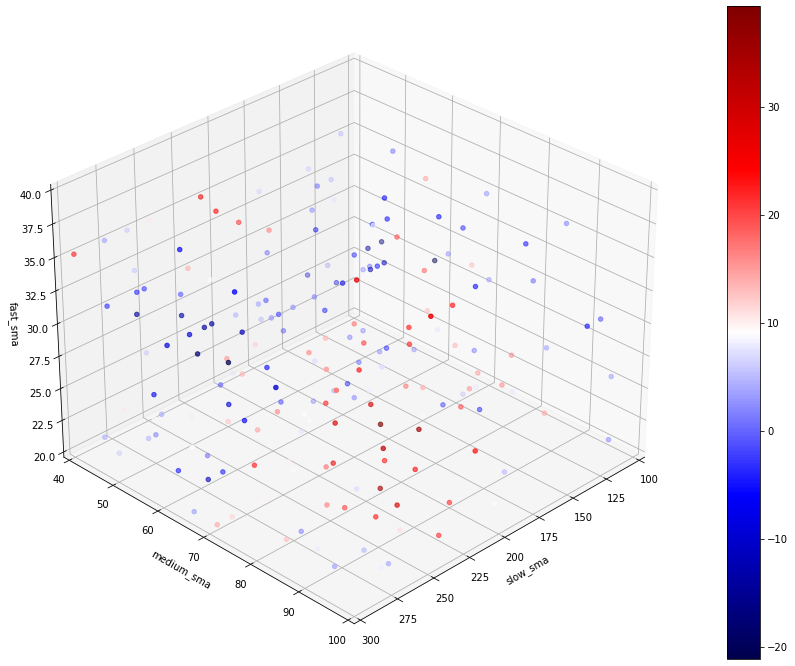

In [183]:
triple_sma_strategy.optimize_strategy(dataset)

### II. Buy and sell the next day ###
1. Buy the stock on the fourth day open, if the stock closes down consecutively for
three days.
2. Exit on the next day open.
3. Optional: Optimise the strategy by exiting the long position on the same day close. Also, you can optimise the number of down days. There are high chances that the number of down days would be different for each stock.